In [1]:
from IPython.display import display
from dataclasses import dataclass
import datetime
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.options.display.max_columns = None

from elarb.policy import (
    create_policy_input, optimal_policy, PolicyInput, PolicyOutput
)
from elarb.models import (
    SolarPanel,
    Battery,
    GridConnection,
    Inverter,
    Facility,
)
from elarb import datasets

## Load data

In [35]:
BIGNUM = 1000

df_nordpool = pd.read_csv('../data/nordpool_21_22.csv', parse_dates=['HourUTC', 'HourDK', 'Date'])
df_pv = (
    pd.read_csv('../data/pvwatts.csv')
    .loc[:, ['Month', 'Day', 'Hour', 'DC Array Output (W)']]
)
df = df_nordpool.copy()
df['Month'] = df.HourDK.dt.month
df['Day'] = df.HourDK.dt.day
df = (
    df.merge(df_pv, on=['Month', 'Day', 'Hour'])
    .drop(columns=['HourUTC', 'SpotPriceEUR', 'Date', 'Hour', 'Month', 'Day'])
    .drop_duplicates()
    .sort_values(by='HourDK')
    .rename(columns={
        'DC Array Output (W)': 'pv_dc_kWh_m2',
        'HourDK': 'ts',
        'PriceArea': 'price_area',
        'SpotPriceDKK': 'spot_price',
    })
    .reset_index(drop=True)
    .set_index('ts')
)
df['net_tariff'] = 0.0
df['spot_demand_kWh'] = BIGNUM
df['spot_supply_kWh'] = BIGNUM
df['spot_price'] /= 1000
df[df['pv_dc_kWh_m2']>0]

,price_area,spot_price,pv_dc_kWh_m2,net_tariff,spot_demand_kWh,spot_supply_kWh
ts,,,,,,
2021-01-01 09:00:00,DK2,0.33395,8.4,0.0,1000,1000
2021-01-01 10:00:00,DK2,0.33485,83.8,0.0,1000,1000
2021-01-01 11:00:00,DK2,0.35122,244.4,0.0,1000,1000
2021-01-01 12:00:00,DK2,0.37785,371.6,0.0,1000,1000
2021-01-01 13:00:00,DK2,0.33849,265.0,0.0,1000,1000
...,...,...,...,...,...,...
2022-10-17 12:00:00,DK2,0.87383,180.1,0.0,1000,1000
2022-10-17 13:00:00,DK2,0.87494,175.1,0.0,1000,1000
2022-10-17 14:00:00,DK2,0.91682,153.2,0.0,1000,1000


<AxesSubplot:>

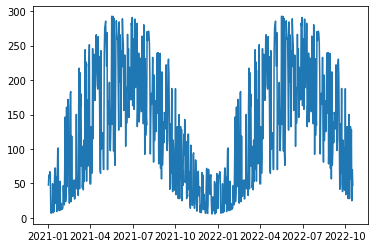

In [3]:
df.groupby(df.index.date).pv_dc_kWh_m2.mean().plot()

In [4]:
df['2022-10-17 13:00:00': '2022-10-17 16:00:00']

,price_area,spot_price,pv_dc_kWh_m2,net_tariff,spot_demand_kWh,spot_supply_kWh
ts,,,,,,
2022-10-17 13:00:00,DK2,874.940002,175.1,0.0,1000,1000
2022-10-17 14:00:00,DK2,916.820007,153.2,0.0,1000,1000
2022-10-17 15:00:00,DK2,1036.630005,73.4,0.0,1000,1000
2022-10-17 16:00:00,DK2,1262.209961,15.9,0.0,1000,1000


In [5]:
datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
#datetime.strptime(, format)

'2022-10-22 19:37:38'

## Configure and optimise

In [6]:
n_panels = widgets.IntSlider(value=100, min=0, max=200, description='Solar panels:', continuous_update=True)
n_inverters = widgets.IntSlider(value=3, min=0, max=10, description='Inverters:', continuous_update=True)
n_batteries = widgets.IntSlider(value=9, min=0, max=10, description='Batteries:', continuous_update=True)
stikledning_amp = widgets.IntSlider(value=63.0, min=0, max=100, description='Ampere:', continuous_update=True)
stikledning_volt = widgets.IntSlider(value=400, min=0, max=500, description='Volt:', continuous_update=True)

In [7]:
display(n_panels)
display(n_inverters)
display(n_batteries)
display(stikledning_amp)
display(stikledning_volt)

IntSlider(value=100, description='Solar panels:', max=200)

IntSlider(value=3, description='Inverters:', max=10)

IntSlider(value=9, description='Batteries:', max=10)

IntSlider(value=63, description='Ampere:')

IntSlider(value=400, description='Volt:', max=500)

## Configuration

In [8]:
# solar panels: 470Wp JinKO TigerNeo N-Type 60HL4 BF, 1.57 kWh / time, costs 1565 DKK
panel = SolarPanel(m2=0.75, depreciation_per_hour=0.0059)
# DK grid
grid = GridConnection(throughput_kWh=stikledning_amp.value * stikledning_volt.value / 1000)
# Deye SUN-12K-SG04LP3-EU
inverter = Inverter(depreciation_per_hour=0.0, throughput_kWh=15.6, conversion_loss_pct=0.03,)
# battery: Powerwall LBATTS Powerwall, 8.8 kwh
battery = Battery(depreciation_per_kWh=0.398, throughput_kWh=3.3, capacity_kWh=8.8, conversion_loss_pct=0.03,)
facility = Facility(
    panel=panel,
    grid=grid,
    inverter=inverter,
    battery=battery,
    n_panels=n_panels.value,
    n_inverters=n_inverters.value,
    n_batteries=n_batteries.value
)
print(facility)

Facility(panel=SolarPanel(m2=0.75, depreciation_per_hour=0.0059), battery=Battery(capacity_kWh=8.8, throughput_kWh=3.3, conversion_loss_pct=0.03, depreciation_per_kWh=0.398), inverter=Inverter(throughput_kWh=15.6, depreciation_per_hour=0.0, conversion_loss_pct=0.03), grid=GridConnection(throughput_kWh=25.2), n_panels=100, n_batteries=9, n_inverters=3)


In [17]:
class Simulator:
    def __init__(self, facility, df):
        self.df = df
        self.facility = facility
    
    def simulate_policy(self, policy, periods, initial_soc=0.0):
        soc = initial_soc
        for start_ts, end_ts in periods:
            period_df = self.df[start_ts:end_ts]
            policy_in = create_policy_input(facility=self.facility, df=period_df, initial_soc=soc)
            outcome = policy(policy_in)
            yield outcome
            soc = outcome.battery_soc_kWh[-1]
        return outcomes
            

In [55]:
simulator = Simulator(facility, df)
t0 = df[df.index.hour == 12].index
t1 = t0 + datetime.timedelta(days=1)
periods = list(zip(t0, t1))
outcomes = list(simulator.simulate_policy(policy=optimal_policy, periods=periods))

/Users/kostas/.venvs/venv-kitchensink/lib/python3.9/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [88]:
df_outcomes = pd.DataFrame({
    'start_ts': [ts0 for (ts0, _) in periods],
    'year_month': [f'{ts0.year}_{ts0.month}' for (ts0, _) in periods],
    'dkk': [o.value for o in outcomes],
    'dkk_x1': [o.x1_contrib for o in outcomes],
    'dkk_x3': [o.x3_contrib for o in outcomes],
    
})
df_outcomes

,start_ts,year_month,dkk,dkk_x1,dkk_x3
0,2021-01-01 12:00:00,2021_1,73.266850,84.032171,3.531113e+01
1,2021-01-02 12:00:00,2021_1,54.478156,64.029924,3.671876e+01
2,2021-01-03 12:00:00,2021_1,57.615328,72.365328,2.389446e-10
3,2021-01-04 12:00:00,2021_1,90.356607,100.354716,3.627335e+01
4,2021-01-05 12:00:00,2021_1,78.323481,87.520105,3.707402e+01
...,...,...,...,...,...
650,2022-10-13 12:00:00,2022_10,852.539892,713.405703,1.854058e+02
651,2022-10-14 12:00:00,2022_10,573.654142,450.960048,1.689657e+02
652,2022-10-15 12:00:00,2022_10,229.335748,167.833765,1.207842e+02
653,2022-10-16 12:00:00,2022_10,238.906646,179.817878,1.053604e+02


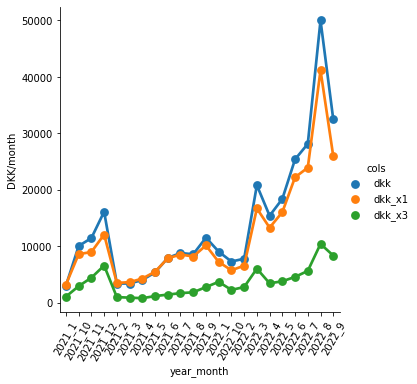

In [92]:
df_plot = (
    df_outcomes
    .groupby('year_month')
    .sum()
    .reset_index()
    .melt('year_month', var_name='cols', value_name='vals')
)
sns.catplot(x="year_month", y="vals", hue='cols', data=df_plot, kind='point')
plt.xticks(rotation=60)
plt.ylabel('DKK/month')
plt.show()

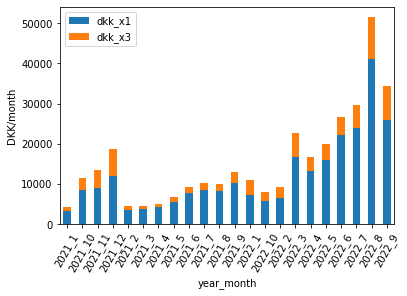

In [94]:
df_plot = (
    df_outcomes
    .drop(columns=['dkk'])
    .groupby('year_month')
    .sum()
)
df_plot.plot(kind='bar', stacked=True)
plt.xticks(rotation=60)
plt.ylabel('DKK/month')
plt.show()